In [0]:
import pandas as pd
import numpy as np

# FOR PLOTTING GRAPHS
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth',300)

# FOR CNN MODEL
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding;
from tensorflow.keras.layers import concatenate, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.layers import Dense, Dropout

# FOR EVALUATION METRICS OF THE PREDICTIONS
from sklearn.metrics import accuracy_score,f1_score

In [0]:
import pickle
variables = pickle.load(open('./drive/My Drive/tempData/variablesword2Vec126','rb'))

test_sequence  = variables['test_sequence']
valid_sequence  = variables['valid_sequence']
train_sequence  = variables['train_sequence']

y_train  = variables['y_train']
y_test  = variables['y_test']
y_valid  = variables['y_valid']

MXSEQLEN  = variables['MXSEQLEN']
EMBEDDING_DIM  = variables['EMBEDDING_DIM']
train_embedding_weights  = variables['train_embedding_weights']
train_word_index  = variables['train_word_index']

In [0]:
def CNN(embedding_weights,num_words):

    embedding_layer = Embedding(
        num_words,                  # VOCABULARY SIZE
        EMBEDDING_DIM,              # ONE HOT ENCODING VECTOR SIZE
        weights=[embedding_weights],# EMBEGGING WEIGHTS FROM THE GOOGLE NEW WORD VECTOR
        input_length=MXSEQLEN,      # MAX LENGTH OF A SEQUENCE
        trainable=False             # PARAMETERS WILL NOT BE TRAINED
    )

    sequence_input      =   Input(shape=(MXSEQLEN,), dtype='int32')
    embedded_sequences  =   embedding_layer(sequence_input)

    conv_layer1 = Conv1D(256, 2, activation='relu')(embedded_sequences)        
    conv_layer1 = GlobalMaxPooling1D()(conv_layer1)

    conv_layer2 = Conv1D(256, 3, activation='relu')(embedded_sequences)        
    conv_layer2 = GlobalMaxPooling1D()(conv_layer2)

    conv_layer3 = Conv1D(256, 4, activation='relu')(embedded_sequences)        
    conv_layer3 = GlobalMaxPooling1D()(conv_layer3)

    next_layer = concatenate([conv_layer1,conv_layer2,conv_layer3])

    next_layer = Dense(128, activation='sigmoid')(next_layer)  
    next_layer = Dropout(0.5)(next_layer)                         
    next_layer = Dense(64, activation='sigmoid')(next_layer)  

    preds = Dense(1, activation='sigmoid')(next_layer)  

    model = Model(sequence_input, preds)
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['acc']
    )
    
    model.summary()
    return model

In [0]:
# len= train_word_index +1 FOR 0 THAT WILL BE PADDED FOR COMPLETING THE SEQUENCE LENGTH
cnn_model = CNN(train_embedding_weights, len(train_word_index)+1)  

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 126)]        0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 126, 300)     1146000     input_8[0][0]                    
__________________________________________________________________________________________________
conv1d_21 (Conv1D)              (None, 125, 256)     153856      embedding_7[0][0]                
__________________________________________________________________________________________________
conv1d_22 (Conv1D)              (None, 124, 256)     230656      embedding_7[0][0]                
____________________________________________________________________________________________

In [0]:
# CONFIGURING AND TRAINING THE MODEL
EPOCHS = 3
BATCH_SIZE = 35

history = cnn_model.fit(
    train_sequence,       # THE INPUT SEQUENCES TO THE MODEL
    y_train,              # TARGET OUTPUT
    epochs=EPOCHS,    
    validation_data=(valid_sequence, y_valid), 
    shuffle=True, 
    batch_size=BATCH_SIZE
)

Epoch 1/3
243/243 [==============================] - 4s 17ms/step - loss: 0.5384 - acc: 0.7507 - val_loss: 0.2452 - val_acc: 0.9076
Epoch 2/3
243/243 [==============================] - 4s 17ms/step - loss: 0.3200 - acc: 0.8676 - val_loss: 0.2262 - val_acc: 0.9004
Epoch 3/3
243/243 [==============================] - 4s 16ms/step - loss: 0.2392 - acc: 0.9087 - val_loss: 0.2300 - val_acc: 0.9064


In [0]:
#####################################################################################
########################## ANALYZING AND TWEAKING THE MODEL##########################
#####################################################################################

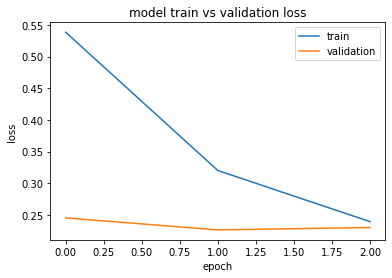

In [0]:
# TRAINING VS VALIDATION LOSS GRAPH
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [0]:
predict=cnn_model.predict(test_sequence)
predict=[int(x+0.5) for x in predict]

In [0]:
# EVLUATING THE ACCURACY
accuracy = accuracy_score(y_test, predict)
f1=f1_score(y_test,predict)
print("F1 Score: %.2f%%" % (f1* 100.0))
print("Accuracy: %.2f%%" % (accuracy * 100.0))

F1 Score: 79.08%
Accuracy: 80.07%
